In [1]:
# !pip install git+https://github.com/nghorbani/human_body_prior
# !conda install pytorch3d -c pytorch3d

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
from bvh import Bvh
from pytorch3d.transforms import euler_angles_to_matrix, matrix_to_axis_angle

In [5]:
mocap_joints = [
    'Hips',
    'LHipJoint',
    'LeftUpLeg',
    'LeftLeg',
    'LeftFoot',
    'LeftToeBase',
    'RHipJoint',
    'RightUpLeg',
    'RightLeg',
    'RightFoot',
    'RightToeBase',
    'LowerBack',
    'Spine',
    'Spine1',
    'Neck',
    'Neck1',
    'Head',
    'LeftShoulder',
    'LeftArm',
    'LeftForeArm',
    'LeftHand',
    'LeftFingerBase',
    'LeftHandIndex1',
    'LThumb',
    'RightShoulder',
    'RightArm',
    'RightForeArm',
    'RightHand',
    'RightFingerBase',
    'RightHandIndex1',
    'RThumb']

smpl_joints = [
    'pelvis',           # 0
    'left_hip',         # 1
    'right_hip',        # 2
    'spine1',           # 3
    'left_knee',        # 4
    'right_knee',       # 5
    'spine2',           # 6
    'left_ankle',       # 7
    'right_ankle',      # 8
    'spine3',           # 9
    'left_foot',        # 10
    'right_foot',       # 11
    'neck',             # 12
    'left_collar',      # 13
    'right_collar',     # 14
    'head',             # 15
    'left_shoulder',    # 16
    'right_shoulder',   # 17
    'left_elbow',       # 18
    'right_elbow',      # 19
    'left_wrist',       # 20
    'right_wrist',      # 21
    'left_index1',      # 22
    'left_index2',      # 23
    'left_index3',      # 24
    'left_middle1',     # 25
    'left_middle2',     # 26
    'left_middle3',     # 27
    'left_pinky1',      # 28
    'left_pinky2',      # 29
    'left_pinky3',      # 30
    'left_ring1',       # 31
    'left_ring2',       # 32
    'left_ring3',       # 33
    'left_thumb1',      # 34
    'left_thumb2',      # 35
    'left_thumb3',      # 36
    'right_index1',     # 37
    'right_index2',     # 38
    'right_index3',     # 39
    'right_middle1',    # 40
    'right_middle2',    # 41
    'right_middle3',    # 42
    'right_pinky1',     # 43
    'right_pinky2',     # 44
    'right_pinky3',     # 45
    'right_ring1',      # 46
    'right_ring2',      # 47
    'right_ring3',      # 48
    'right_thumb1',     # 49
    'right_thumb2',     # 50
    'right_thumb3',     # 51

    # unused for SMPLH
    # 'nose',             # 52
    # 'right_eye',        # 53
    # 'left_eye',         # 54
    # 'right_ear',        # 55
    # 'left_ear',         # 56
    # 'left_big_toe',     # 57
    # 'left_small_toe',   # 58
    # 'left_heel',        # 59
    # 'right_big_toe',    # 60
    # 'right_small_toe',  # 61
    # 'right_heel',       # 62
    # 'left_thumb',       # 63
    # 'left_index',       # 64
    # 'left_middle',      # 65
    # 'left_ring',        # 66
    # 'left_pinky',       # 67
    # 'right_thumb',      # 68
    # 'right_index',      # 69
    # 'right_middle',     # 70
    # 'right_ring',       # 71
    # 'right_pinky',      # 72
]

# joint_mapping = {
#     'left_hip': 'LeftUpLeg',
#     'right_hip': 'RightUpLeg',


#     'neck': 'Head',


#     'left_collar': 'LeftArm',
#     'right_collar': 'RightArm',

# }


smpl_to_mocap = {
    'pelvis': 'Hips',                                 # 0
    'left_hip': 'LHipJoint',                          # 1
    'right_hip': 'RHipJoint',                         # 2
    'spine1': 'LowerBack',                            # 3
    'left_knee': 'LeftLeg',                           # 4
    'right_knee': 'RightLeg',                         # 5
    'spine2': 'Spine',                                # 6
    'left_ankle': 'LeftFoot',                         # 7
    'right_ankle': 'RightFoot',                       # 8
    'spine3': 'Spine1',                               # 9
    'left_foot': 'LeftToeBase',                       # 10
    'right_foot': 'RightToeBase',                     # 11
    'neck': 'Neck',                                   # 12
    'left_collar': 'LeftShoulder',                    # 13
    'right_collar': 'RightShoulder',                  # 14
    'head': 'Head',                                   # 15
    'left_shoulder': 'LeftArm',                       # 16
    'right_shoulder': 'RightArm',                     # 17
    'left_elbow': 'LeftForeArm',                      # 18
    'right_elbow': 'RightForeArm',                    # 19
    'left_wrist': 'LeftHand',                         # 20
    'right_wrist': 'RightHand',                       # 21
    'left_index1': 'LeftHandIndex1',                  # 22
    'left_index2': '-',          # not available      # 23
    'left_index3': '-',          # not available      # 24
    'left_middle1': '-',         # not available      # 25
    'left_middle2': '-',         # not available      # 26
    'left_middle3': '-',         # not available      # 27
    'left_pinky1': '-',          # not available      # 28
    'left_pinky2': '-',          # not available      # 29
    'left_pinky3': '-',          # not available      # 30
    'left_ring1': '-',           # not available      # 31
    'left_ring2': '-',           # not available      # 32
    'left_ring3': '-',           # not available      # 33
    'left_thumb1': 'LThumb',                          # 34
    'left_thumb2': '-',          # not available      # 35
    'left_thumb3': '-',          # not available      # 36
    'right_index1': 'RightHandIndex1',                # 37
    'right_index2': '-',         # not available      # 38
    'right_index3': '-',         # not available      # 39
    'right_middle1': '-',        # not available      # 40
    'right_middle2': '-',        # not available      # 41
    'right_middle3': '-',        # not available      # 42
    'right_pinky1': '-',         # not available      # 43
    'right_pinky2': '-',         # not available      # 44
    'right_pinky3': '-',         # not available      # 45
    'right_ring1': '-',          # not available      # 46
    'right_ring2': '-',          # not available      # 47
    'right_ring3': '-',          # not available      # 48
    'right_thumb1': 'RThumb',                         # 49
    'right_thumb2': '-',         # not available      # 50
    'right_thumb3': '-',         # not available      # 51
    'nose': '-',                 # not available      # 52
    'right_eye': '-',            # not available      # 53
    'left_eye': '-',             # not available      # 54
    'right_ear': '-',            # not available      # 55
    'left_ear': '-',             # not available      # 56
    'left_big_toe': '-',         # not available      # 57
    'left_small_toe': '-',       # not available      # 58
    'left_heel': '-',            # not available      # 59
    'right_big_toe': '-',        # not available      # 60
    'right_small_toe': '-',      # not available      # 61
    'right_heel': '-',           # not available      # 62
    'left_thumb': '-',           # not available      # 63
    'left_index': '-',           # not available      # 64
    'left_middle': '-',          # not available      # 65
    'left_ring': '-',            # not available      # 66
    'left_pinky': '-',           # not available      # 67
    'right_thumb': '-',          # not available      # 68
    'right_index': '-',          # not available      # 69
    'right_middle': '-',         # not available      # 70
    'right_ring': '-',           # not available      # 71
    'right_pinky': '-',          # not available      # 72
}

In [6]:
# mocap_unconverted_joints
set(mocap_joints) - {smpl_to_mocap[j] for j in smpl_to_mocap}  

{'LeftFingerBase', 'LeftUpLeg', 'Neck1', 'RightFingerBase', 'RightUpLeg'}

In [7]:
bvh_file_path = 'angry_12_000.bvh'
# bvh_file_path = 'childlike_12_000.bvh'
# bvh_file_path = 'depressed_12_000.bvh'
name = bvh_file_path.split(".")[0]
print(name)
with open("input/" + bvh_file_path) as f:
    bvh = Bvh(f.read())

angry_12_000


In [8]:
def get_joint_euler_angles(bvh_data, frame_idx, joint_name):
    return [
        bvh_data.frame_joint_channel(frame_idx, joint_name, ch)
        for ch in [ 'Xrotation', 'Yrotation', 'Zrotation', ] ]

# 2. Helpers
def euler_deg_to_axis_angle(euler_angles_deg, order='XYZ'):
    """
    Convert Euler angles (deg) to Axis-Angle tensor (shape [3])
    """
    euler_rad = torch.tensor(euler_angles_deg) * torch.pi / 180.0
    rot_matrix = euler_angles_to_matrix(euler_rad, convention=order)  # (3,3)
    axis_angle = matrix_to_axis_angle(rot_matrix)  # (3,)
    return axis_angle


In [ ]:
frame_pose_list = []
for frame_idx in range(bvh.nframes):
    frame_pose = []

    # for smplh_joint in smpl_joints:
    for j in smpl_joints:
        mocap_joint = smpl_to_mocap[j]

        # mocap_joint = smpl_to_mocap.get(smplh_joint)

        if mocap_joint != "-":
            euler_angles = get_joint_euler_angles(bvh, frame_idx, mocap_joint)
            axis_angle = euler_deg_to_axis_angle(euler_angles, order='XYZ')
        else:
            axis_angle = torch.zeros(3)  # If no mocap source, fill with zeros

        frame_pose.append(axis_angle)

    frame_pose = torch.stack(frame_pose)  # [smplh_num_joints, 3]

    frame_pose_list.append(frame_pose)

pose_all = torch.stack(frame_pose_list)
pose_all = pose_all.reshape(pose_all.shape[0], -1)

In [ ]:
import torch
from human_body_prior.body_model.body_model import BodyModel
from human_body_prior.tools.omni_tools import copy2cpu as c2c


device = 'cuda' if torch.cuda.is_available() else 'cpu'


HAND_FULL_JOINTS = np.arange(15)
HAND_2_JOINTS = np.concatenate([np.arange(3), np.arange(12, 15)])
R_HAND_START_INDEX = 37
L_HAND_START_INDEX = 22
JOINTS_SART_INDEX = 1
BASE_JOINTS = np.arange(22)
R_HAND_FULL = HAND_FULL_JOINTS + R_HAND_START_INDEX
R_HAND_2 = HAND_2_JOINTS + R_HAND_START_INDEX
L_HAND_FULL = HAND_FULL_JOINTS + L_HAND_START_INDEX
L_HAND_2 = HAND_2_JOINTS + L_HAND_START_INDEX


# for ploting original 50002_chicken_wings_poses data
# pose_all = data["poses"] 

root_orient = torch.Tensor(pose_all[:, :(JOINTS_SART_INDEX * 3)]).to(device)
pose_hand = torch.Tensor(pose_all[:, (L_HAND_START_INDEX * 3):]).to(device)
pose_body = torch.Tensor(pose_all[:, (JOINTS_SART_INDEX * 3):(
            L_HAND_START_INDEX * 3)]).to(device)
model_path = '../../models/smplh/models/neutral/SMPLH_NEUTRAL.npz'

body_model = BodyModel(bm_fname=model_path, num_betas=16).to(device)

bm_out = body_model(pose_body=pose_body, pose_hand=pose_hand, root_orient=root_orient)



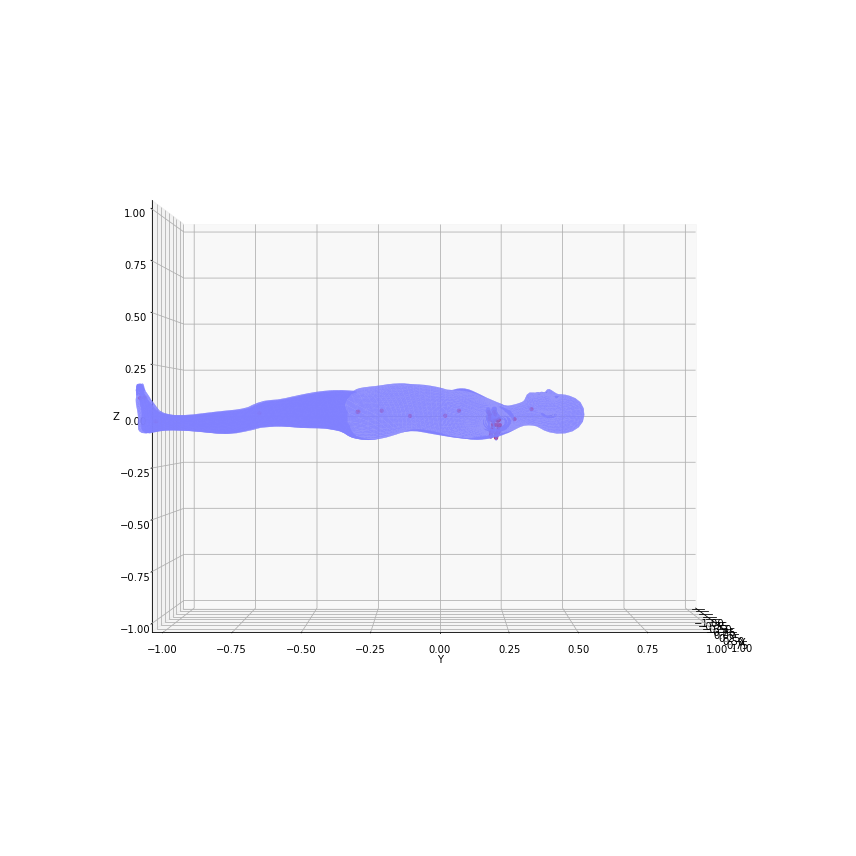

In [11]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

# def plot_mesh_matplotlib(vertices, faces, title='SMPL-H Mesh'):
# Use it after SMPL-H output



# Run after SMPL-H forward pass
idx = 10
vertices = bm_out.v[idx].detach().cpu().numpy()
faces = bm_out.f.detach().cpu().numpy()


fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(vertices[faces], alpha=0.7)
mesh.set_facecolor([0.5, 0.5, 1, 0.7])
ax.add_collection3d(mesh)

# Auto scale to the mesh size
x, y, z = vertices.T
# ax.set_xlim([x.min(), x.max()])
# ax.set_ylim([y.min(), y.max()])
# ax.set_zlim([z.min(), z.max()])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=0, azim=0)


x, y, z = bm_out.Jtr[idx].T.cpu().detach().numpy()

# plt.scatter(x, y, z)
ax.scatter(x, y, z, c='r', marker='o', alpha=1, s=10)  # Scatter plot for the points

plt.tight_layout()
plt.show()

Video saved as 'angry_12_000.mp4'


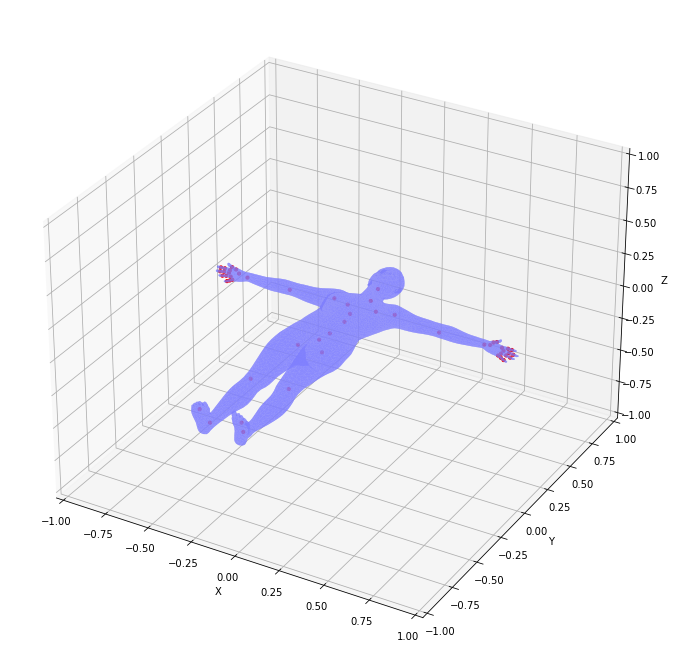

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.animation as animation

# Create a figure and 3D axes
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# Initialization function for the animation
def init():
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    return []

# Animation function called sequentially
def animate(idx):
    ax.cla()  # Clear previous mesh and points
    
    vertices = bm_out.v[idx].detach().cpu().numpy()
    faces = bm_out.f.detach().cpu().numpy()

    mesh = Poly3DCollection(vertices[faces], alpha=0.7)
    mesh.set_facecolor([0.5, 0.5, 1, 0.7])
    ax.add_collection3d(mesh)

    x, y, z = vertices.T
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Plot joints
    jtr_x, jtr_y, jtr_z = bm_out.Jtr[idx].T.cpu().detach().numpy()
    ax.scatter(jtr_x, jtr_y, jtr_z, c='r', marker='o', alpha=1, s=10)

    return []

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=range(pose_all.shape[0]), init_func=init, blit=False)

# Save the animation
ani.save('3.2.output/%s.mp4' % name, writer='ffmpeg', fps=30)

print("Video saved as '%s.mp4'" % name)
